# STAT 201 FINAL PROJECT REPORT


#### GROUP #23: Zihua Li, Alex Pan Wang, Kaylan Wallace, Tim Zeng
<br>

# **Cholesterol Levels and Heart Disease: A Comparative Analysis of Risks**

In [1]:
# import libraries
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


***
## __Introduction__:
Heart disease is a global health concern encompassing conditions affecting the heart and blood vessels. High cholesterol levels, defined as >=240mg/dL (Johns Hopkins Medicine, 2020), are a recognized risk factor associated with heart disease. 
Cholesterol is a fatty substance found in our cells and diet that is crucial in cellular functions and hormone production. However, elevated cholesterol levels can lead to plaque buildup in arteries, constraining blood flow and raising the risk of heart-related issues. In recent years, heart disease has caused a substantial rise in fatalities, with a surge of over 2 million deaths since 2000, reaching 8.9 million deaths by 2019 (WHO, 2020). Maintaining healthy cholesterol levels is imperative for mitigating the risk of heart disease, highlighting the importance of monitoring and managing cholesterol levels.

<br><br>

#### __Research question__
Our study seeks to investigate the relationship between cholesterol levels and the incidence of heart disease. Specifically, we aim to answer the following question: 

>  Is there a significant difference in the proportions of patients diagnosed with heart disease between those with high cholesterol levels (defined as ≥240mg/dL) and those with normal or below-average cholesterol levels?

<br>

#### __Choice of parameter__
Proportion in High Cholesterol Group: 
> The proportion (or percentage) of patients who have high cholesterol levels (≥240mg/dL) and are diagnosed with heart disease.

Proportion in Normal/Below-Average Cholesterol Group: 
> The proportion of patients who have normal or below-average cholesterol levels (less than 240mg/dL) and are diagnosed with heart disease.

<br>

#### __Dataset description__
We will use the Heart Disease dataset from the UC Irvine Machine Learning Repository. It has 14 attributes measured across three geographic samples. We will use a subset of the original dataset, namely the age, cholesterol levels measured in milligrams per deciliter of blood (mg/dl), and diagnosis for patients from Cleveland.

<br><br>

#### __Response Variable__
The response variable is the diagnosis of heart disease.

<br><br>

#### __Explanatory Variable__
The explanatory variable is the cholesterol level of the patients, categorized into two groups: high cholesterol levels (≥240mg/dL) and normal or below-average cholesterol levels (below 240mg/dL).

<br><br>

*** 
#### __Preliminary Results__:

#### __Data Acquisition__
To begin our analysis, we will access the Heart Disease dataset, specifically the subset of data pertaining to patients from the Cleveland clinic. Available in CSV format from the UC Irvine Machine Learning Repository, the dataset was created by renowned cardiologists with more than 300 samples. It has been cited 64 times and was published in the American Journal of Cardiology; therefore, we can conclude the data is authentic, authoritative, trustworthy, and generalizable to the population we wish to explore.

In [2]:
# STEP 1: Read the data from the web 
data <- read.table("https://raw.githubusercontent.com/Kaylan-W/STAT-201-Final-Project/main/data/processed.cleveland.data", 
                   sep = ",", header = FALSE, na.strings = "?")
 
# Assign column names to the dataframe
colnames(data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")


##### Table 1: Subset of the raw data

In [3]:
head(data) 

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


<br><br>

#### __Exploratory Data Analysis__
We first refine the diagnosis (num) column such that a value of '0' is represents the 'absence' of heart disease, and values '1', '2', '3', and '4' represent the 'presence' of heart disease. This categorization simplifies the dataset into a binary classification system, essential for our analysis and ease of interpretation.

Then, we transform the cholesterol (chol) column. Using a threshold of 240mg/dL, cholesterol levels equal to or above the threshold are labeled as 'High', while those below are classified as 'Normal/Below-Average'.

To illustrate the relationship between the variables, we construct a bar plot. This visual representation will aid in discerning any apparent patterns between cholesterol levels and heart disease diagnoses.

Lastly, we select only the relevant columns for our study and eliminate any rows with missing values (NA).  

In [4]:
# STEP 2: Clean and wrangle data
# Tidy target column by combining values to make a binary feature
mutate_num <- data %>%
    mutate(diagnosis = case_when(num == 0 ~ "absence",
                                 num == 1 ~ "presence",
                                 num == 2 ~ "presence",
                                 num == 3 ~ "presence",
                                 num == 4 ~ "presence"))

# Set threshold value for categorization 
threshold = 240

# Turn chol into a categorical variable with the categories "High Chol" and "Normal/Below-Avg Chol"
mutate_chol <- mutate_num %>%
    mutate(chol_level = case_when(chol >=  threshold ~ "High",
                                  chol < threshold ~ "Normal/Below-Avg"))


# Select relevant columns and handle NA values. 
data_downsized<- mutate_chol %>%
        select(age, chol, chol_level, diagnosis, -num) %>%
        na.omit()


#STEP 3: Compute estimates of the parameter identified across groups.
prop_diagnosis_by_chol <- data_downsized %>%
  group_by(chol_level) %>%
  summarise(disease_count = sum(diagnosis == "presence"),
            n = n(),
            proportion = disease_count / n,
            mean_chol = mean(chol, na.rm = TRUE),
            median_chol = median(chol, na.rm = TRUE),
            sd_chol = sd(chol, na.rm = TRUE),
            var_chol = var(chol, na.rm = TRUE))

# STEP 4: Create a bar chart
prop_bar <- ggplot(data_downsized, aes(x = chol_level, fill = diagnosis)) +
  geom_bar() +
  labs(title = "Figure 1: Proportion of Patients with Heart Disease by Cholesterol Level",
       x = "Cholesterol Level",
       y = "Count",
       fill = "Heart Disease Diagnosis") +
  scale_fill_manual(values = c("absence" = "lightgreen", "presence" = "pink"))

##### Table 2: Proportion of Patients with Heart Disease by Cholesterol Level

In [5]:
prop_diagnosis_by_chol

chol_level,disease_count,n,proportion,mean_chol,median_chol,sd_chol,var_chol
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,80,156,0.5128205,284.4423,274,41.63888,1733.7967
Normal/Below-Avg,59,147,0.4013605,206.6327,211,23.79510,566.2066


<br><br>

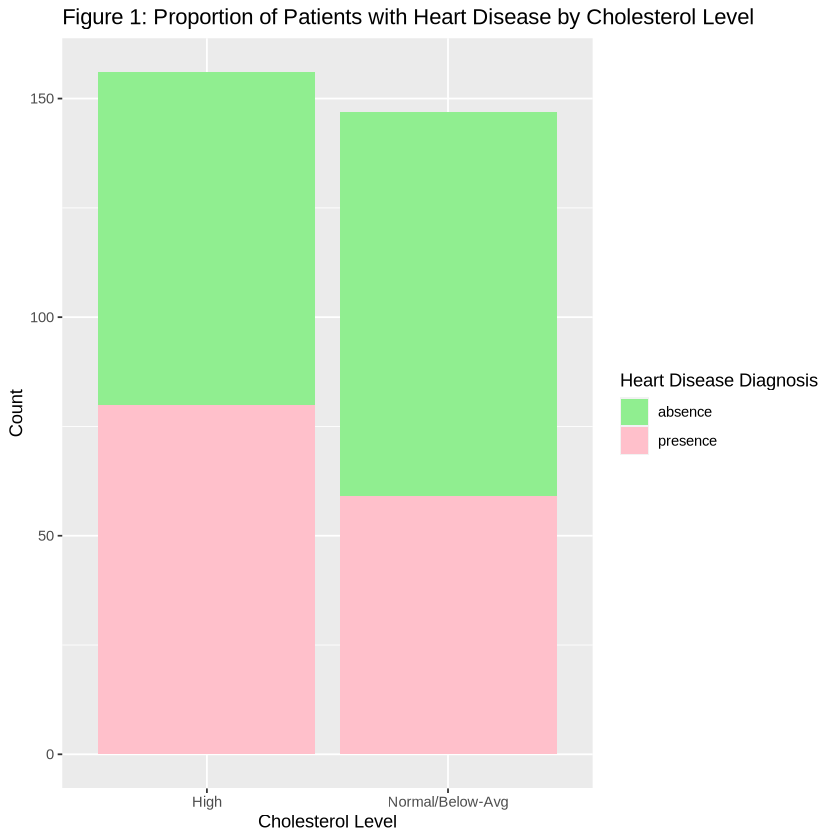

In [6]:
prop_bar

<br>
Figure 1 shows that patients with high cholesterol level are more likely to be diagnosed with heart disease. We will quantify the diagnosis rate by computing the proportion of patient diagnosis with heart disease in each group.

<br>

##### Table 3: Tally of Diagnosis Type by Cholesterol Level

In [7]:
data_downsized |>
    group_by(chol_level, diagnosis) |>
    tally()

chol_level,diagnosis,n
<chr>,<chr>,<int>
High,absence,76
High,presence,80
Normal/Below-Avg,absence,88
Normal/Below-Avg,presence,59


<br>
Of all the patients with high cholesterol levels, 80 of 156 were diagnosed with heart disease, resulting in a proportion of 51.3%
<br><br>
Conversely, for all patients with normal or below-average cholesterol levels, 59 of 147 were diagnosed with heart disease, for a proportion of 40.1%
<br><br>
It seems that patients with high cholesterol are diagnosed with heart disease at an 11.2% higher rate, suggesting a correlation between high cholesterol levels and the incidence of heart disease. But does this difference provide definitive proof that high cholesterol is a direct cause of increased heart disease diagnoses?  
<br><br><br>

***
## Methods:
#### __Plan__
The initial data analysis has give us an understanding of the association between cholesterol levels and heart disease. However, these exploratory tools alone are not adequate for informed decision-making. Next, we will conduct hypothesis testing via two different methods for comparison, and construct confidence intervals to find the statistical significance and reliability of our observed differences.

<br><br>

#### __Hypothesis Tests for the Difference in Proportions__
$H_0$: Patients with high cholesterol levels are diagnosed with heart disease at the same rate as patients with normal/below-average cholesterol levels.
>$H_0$: $p_1$ - $p_2$ $=$ $0$

$H_1$: Patients with high cholesterol levels are diagnosed with heart disease at a higher rate than patients with normal/below-average cholesterol levels.
>$H_1$: $p_1$ - $p_2$ $>$ $0$

- Let $p_1$ represent the proportion of the patients who have high cholesterol levels and diagnosis of heart disease.

- Let $p_2$ represent the proportion of the patients with the normal/below-average cholesterol levels and diagnosis of heart disease.

<br><br>

#### __Observed test statistic__
In the context of our project, we consider the two samples to be patients with high cholesterol levels and patients with normal or below-average cholesterol levels. Thus, our point estimate of interest is the difference in sample proportions between these two groups.

The observed proportions of heart disease diagnoses are 51.3% in the high cholesterol group and 40.1% in the normal/below-average cholesterol group, resulting in an observed difference of 11.2%.

<br><br>

#### __Hypothesis Tests via Bootstrapping__
We will conduct the hypothesis tests using the infer workflow to generate replicates of the dataset, assuming the null hypothesis is true, using permutation.

##### Table 4: Subset of the Generated Null Distribution

In [8]:
set.seed(123)

null_distribution <- data_downsized %>% 
  specify(formula = diagnosis ~ chol_level, success = "presence") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 1000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("High", "Normal/Below-Avg"))

head(null_distribution)

replicate,stat
<int>,<dbl>
1,0.018969126
2,-0.007456829
3,-0.086734694
4,-0.060308739
5,-0.047095761
6,-0.073521716


<br>

We have 1000 instances of the test statistic, each one representing a potential difference in the proportion of patients with heart disease between those with high cholesterol levels and those with normal/below-average cholesterol levels. These values form our `null_distribution`, which is key to our hypothesis testing as it represents the variation of our test statistic in a scenario where there is no actual association between cholesterol levels and heart disease diagnoses.

Now we can compute the observed test value.

In [9]:
obs_diff_prop <- data_downsized %>% 
  specify(formula = diagnosis ~ chol_level, success = "presence") %>% 
  calculate(stat = "diff in props", order = c("High", "Normal/Below-Avg"))

cat("Observed test value =", obs_diff_prop$stat)

Observed test value = 0.11146

<br><br>
Now we visualize the null distribution and plug in the observed difference using the `shade_p_value()` function. We'll set the `direction = "right"`, reflecting our alternative hypothesis. "More extreme" in this context corresponds to differences that are "larger" or "more positive".

##### Figure 2: The Null Distibution and Observed Difference in Proportions

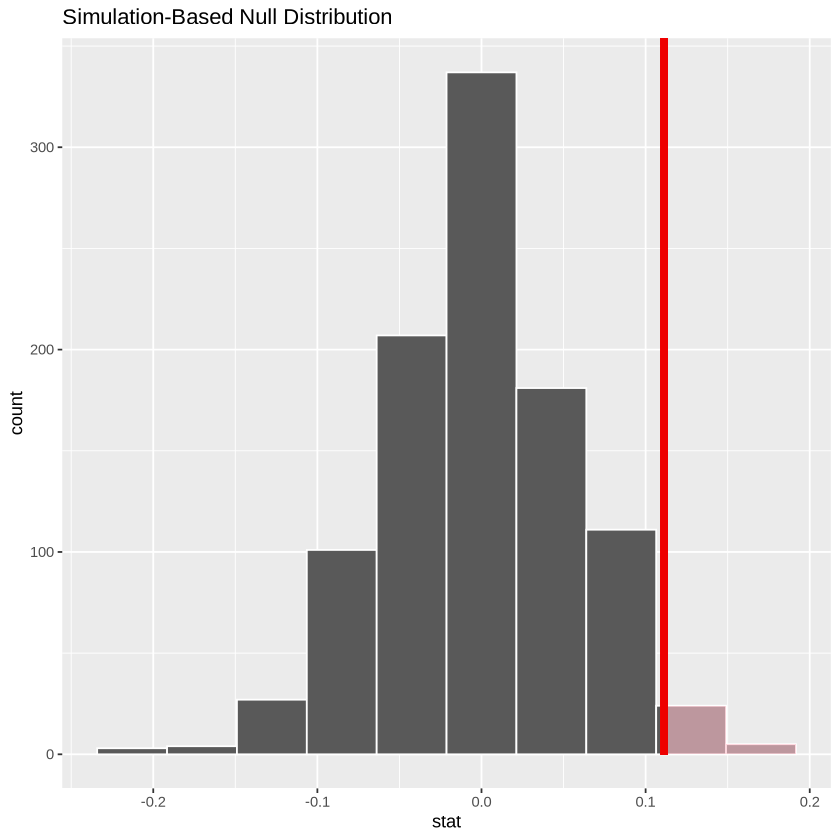

In [10]:
visualize(null_distribution, bins = 10) +
    shade_p_value(obs_stat = obs_diff_prop, direction = "right")

<br>

**Figure 2** represents a simulation-based null distribution, and the solid red line indicates the observed difference in proportions. The shaded area to the right of this line corresponds to the p-value, which is the probability of observing a test statistic as extreme as, or more extreme than, what was observed in our data, assuming that the null hypothesis is true.

From **Figure 2**, the likelihood of observing a test statistic as extreme as the one indicated by the solid line is quite low. This suggests that the observed difference is statistically significant. In the context of our study, if this shaded region represents the p-value for the difference in heart disease rates between patients with high and normal/below-average cholesterol levels, it seems that we would rarely observe such a difference if cholesterol levels actually had no real effect on heart disease.

To get the exact p-value, we can the R function `get_p_value()`. If the p-value is below our chosen significance level (α = 0.05), we would reject the null hypothesis. 

In [11]:
null_p_value <- null_distribution %>% 
  get_p_value(obs_stat = obs_diff_prop, direction = "right")

cat("Calculated p-value =", null_p_value$p_value)


Calculated p-value = 0.029

<br>

The calculated **p-value** from our analysis is 0.029, or 2.9%. Since this is less than our significance level of 0.05, we reject the null hypothesis. We now have sufficient evidence to support the claim that high cholesterol levels are associated with higher rates of heart disease diagnoses. It's important to note that the decision to reject the null hypothesis is primarily influenced by our chosen significance level α.

Now we will create a bootstrap distribution and calculate a 95% confidence interval (CI) to provide a representation of the uncertainty associated with our findings.
<br>

In [12]:
bootstrap_distribution <- data_downsized %>% 
    specify(formula = diagnosis ~ chol_level, success = "presence") %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in props", order = c("High", "Normal/Below-Avg"))

percentile_ci <- bootstrap_distribution %>% 
  get_confidence_interval(level = 0.95, type = "percentile")

percentile_ci_viz <- visualize(bootstrap_distribution) + 
  shade_confidence_interval(endpoints = percentile_ci)

cat("Lower bound of the percentile based confidence interval =", percentile_ci$lower_ci)
cat("\nUpper bound of the percentile based confidence interval =", percentile_ci$upper_ci)

Lower bound of the percentile based confidence interval = 0.005103476
Upper bound of the percentile based confidence interval = 0.2194763

##### Figure 3: 95% Percentile Based Confidence Interval for the Bootstrap Distribution

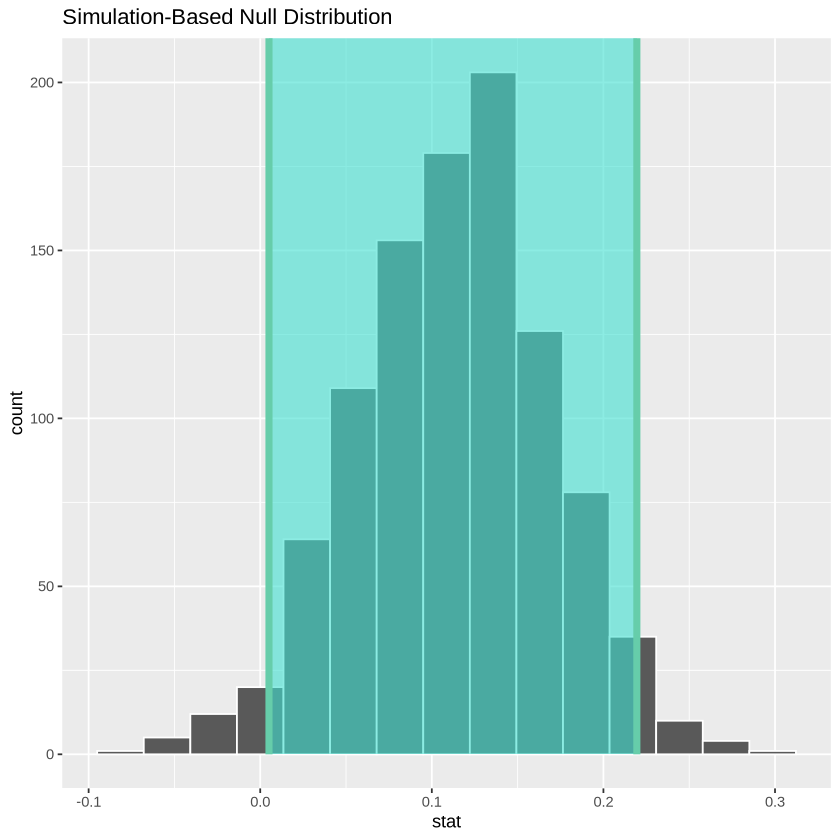

In [13]:
percentile_ci_viz

<br>

Looking at Figure 3, it is noteworthy that the 95% confidence interval for the difference in proportions excludes the value 0. This implies a significant divergence, and thus a real difference between the two compared proportions.

Given the approximately normal shape of the bootstrap distribution presented, we can employ the standard error method for further analysis:

In [14]:
se_ci <- bootstrap_distribution %>% 
  get_confidence_interval(level = 0.95, type = "se", 
                          point_estimate = obs_diff_prop)
 
cat("Lower bound of the standard error based confidence interval =", se_ci$lower_ci)
cat("\nUpper bound of the standard error based confidence interval =", se_ci$upper_ci)

se_ci_viz <- visualize(bootstrap_distribution) + 
  shade_confidence_interval(endpoints = se_ci)

Lower bound of the standard error based confidence interval = 0.0009386403
Upper bound of the standard error based confidence interval = 0.2219813

##### Figure 4: 95% Standard Error Based Confidence Interval for the Bootstrap Distribution

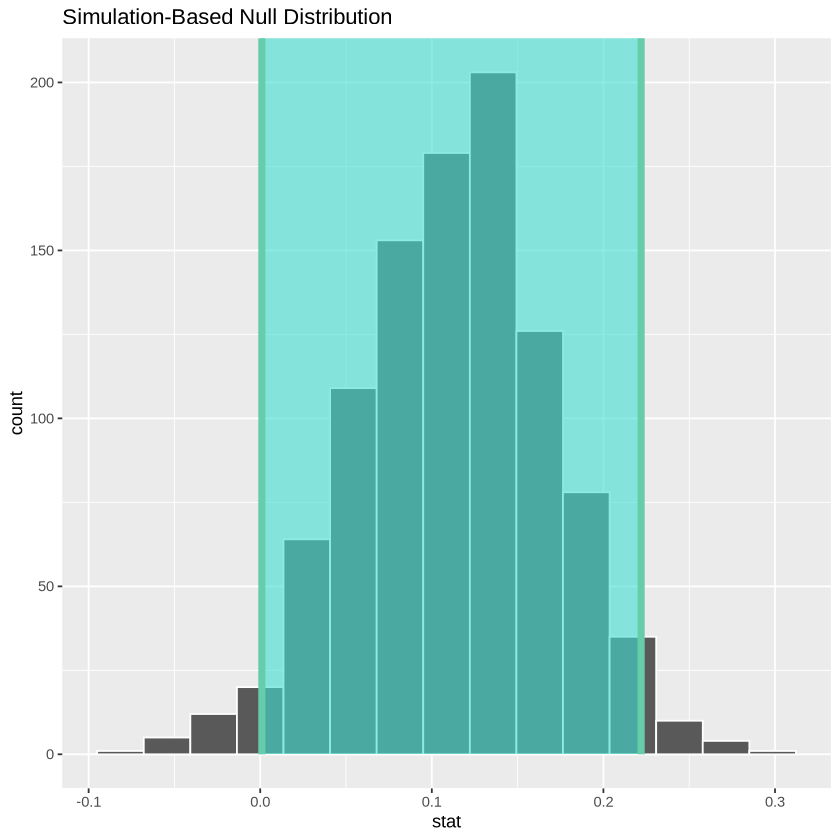

In [15]:
se_ci_viz

<br><br>

#### **Hypothesis Test via Asymptotic Method:**
Given that we are comparing proportions and not means, and that the population standard deviation is not relevant for proportions, we can use an asymptotic method that is suitable, `prop.test`.

Our sample is big enough (over 30 people in each group), and each person's data is independent from the others, making `prop.test` a good choice. The significance level will remain at α = 0.05.

The resulting p-value of 0.03358 is again less than the significance level of 0.05, suggesting that we can reject the null hypothesis. Furthermore, the 95% confidence interval again does not include 0, further supporting our finding that there is a statistically significant difference.

In [16]:
# We will set up the prop.test function with x being the number of patients diagnosed with heart 
# disease in each group, and n being the total number of patients in each group:
x <- c(80, 59) 

n <- c(156, 147)  

test_result <- prop.test(x, n, alternative = "greater")

print(test_result)


	2-sample test for equality of proportions with continuity correction

data:  x out of n
X-squared = 3.3511, df = 1, p-value = 0.03358
alternative hypothesis: greater
95 percent confidence interval:
 0.01128455 1.00000000
sample estimates:
   prop 1    prop 2 
0.5128205 0.4013605 



<br><br>

***
## Discussion:

#### __Types of Errors__
While doing our analysis, we need to consider two potential errors:

- Type I Error (False Positive): We conclude that there is a difference in the rate of heart disease diagnosis between the two groups (rejecting  𝐻0) when in reality no such difference exists. This false difference can be, for example, concluding that patients with high cholesterol have a higher rate of heart disease when in fact, the rates are the same.

- Type II Error (False Negative): We fail to detect a difference between patients with high and normal/below-average cholesterol levels (failing to reject 𝐻0) when there actually is one. 

We carefully choose our significance level (α) to minimize the risk of a Type I error.

<br><br>

#### __Percentile-Based vs. Standard Error Confidence Interval Calculations__
We have calculated the confidence interval by using Percentile-based and Standard Error methods. We use the standard error method when the bootstrap distribution is approximately normal shape. But, if the distribution isn't approximately normal shape, we should consider using the percentile method.

Both methods produce similar confidence intervals, with the lower and upper bounds aligning closely. The consistency between the two methods enhances the credibility of our findings, indicating that our point estimate for the difference in proportions is stable. This strengthens our confidence in the conclusion that there is a statistically significant difference in the rates of heart disease diagnosis between the two cholesterol level groups.

<br><br>

#### __Bootstrap Method vs Asymptotic Method__
Bootstrapping produced a p-value of 0.029, indicating a statistically significant difference between the high cholesterol and normal cholesterol groups in the rate of heart disease diagnosis. The 95% confidence interval obtained through both the percentile and standard error approach ranged from approximately 0.0051 to 0.2195.

The asymptotic method provided a p-value of 0.03358. The corresponding 95% confidence interval using this method spanned from 0.0113 to 1.0, again not including the null value and indicating statistical significance.

Given that the asymptotic method may be more efficient with large samples, and that bootstrapping is more computationally demanding, the choice between these methods often depends on the sample size and distribution assumptions. 

To conclude, the similarity between the p-values and confidence intervals from both methods suggests that our results are robust; it lends confidence to the conclusion that there is indeed a statistically significant difference in the rates of heart disease diagnosis between patients with high and normal cholesterol levels.

These results aligned with our expectations based on existing literature on heart disease causes. These findings could be informative in the medical field, but also in the average person's daily decision-making. This evidence that patients with higher cholesterol levels may have greater risks of heart disease may help citizens recognize the need for lifestyle changes to reduce their cholesterol levels. In turn, the annual number of heart disease cases may decline in the long run. However, given the limited size of our sample in relation to the actual population, there is potential for more in depth research to further understand the risk factors for heart disease, such as:
1. Is a high cholesterol level the primary cause of heart disease?
2. Are there any other factors that will lead to heart disease?
3. Are older persons more at risk for heart disease than younger persons? 

<br><br>

***
## References:

- Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository: https://doi.org/10.24432/C52P4X
- Lipid panel. Johns Hopkins Medicine. (2020, December 4). https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/lipid-panel#:~:text=Here%20are%20the%20ranges%20for,or%20above%20240%20mg%2FdL 
- World Health Organization: WHO. (2020, December 9). The top 10 causes of death. https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death
- ModernDive, Chapter 8 Bootstrapping and Confidence Intervals: https://moderndive.com/8-confidence-intervals.html
- 4.4.1 - StatKey: Standard Error Method - STAT ONLINE: https://online.stat.psu.edu/stat200/book/export/html/90#:~:text=The%20standard%20error%20method%20can,percentile%20method%20must%20be%20used.